In [1]:
import numpy as np
import math as m
import pandas as pd
from datetime import datetime
from pathlib import Path
from parse import parse
import matplotlib
from matplotlib import pyplot as plt
from crr_model import price
from matplotlib.ticker import PercentFormatter
from matplotlib.patches import Rectangle
from cycler import cycler
from adjustText import adjust_text



In [2]:
# Configure the matplotlib
from matplotlib import rc

# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})

# Set the font used for MathJax - more on this later
rc('mathtext',**{'default':'regular'})

%matplotlib inline

# The following %config line changes the inline figures to have a higher DPI.
# You can comment out (#) this line if you don't have a high-DPI (~220) display.
%config InlineBackend.figure_format = 'retina'

## Data Processing

In [3]:
exchange_rate_dir = Path('../../data/exchange-rate/')

def get_coin_pairs(f=None):
    pairs = []
    for x in exchange_rate_dir.iterdir():
        if x.is_file():
            c1, c2 = parse('{}-{}.csv', x.name)
            if f != None and f != c1:
                continue
            pairs.append([c1, c2])
    return pairs

def coin_data_df(coin1, coin2):
    filename = exchange_rate_dir / '{}-{}.csv'.format(
        coin1, coin2)
    df = pd.read_csv(filename,
                     index_col=['datetime'],
                     names=['datetime', 'price'])
    df.index = pd.to_datetime(df.index, unit='ms')
    df['price_pct_change'] = df['price'].pct_change()
    return df

def forex_data_df(c1, c2):
    df = pd.read_csv('../../data/forex/{}-{}.csv'.format(c1, c2))
    df['datetime'] = df['Date']
    df['price'] = df['Price']
    df['price_pct_change'] = df['price'].pct_change()
    return df

def stock_index_df(c):
    df = pd.read_csv('../../data/stock-index/{}.csv'.format(c))
    df['datetime'] = df['Date']
    df['price'] = df['Open']
    df['price_pct_change'] = df['price'].pct_change()
    return df

def get_v_info(df):
    v_ser = df['price_pct_change']
    v_up, v_down = v_ser[lambda x: x>0], v_ser[lambda x: x<0]
    return [v_up.mean(), float(v_up.size)/float(v_ser.size), v_down.mean(), float(v_down.size)/float(v_ser.size)]

# all data
data = dict()
# cryptocurrency data
pairs = get_coin_pairs(f='btc')
for i, pair in enumerate(pairs):
    c1, c2 = pair[0], pair[1]
    data['{}-{}'.format(c1, c2)] = [coin_data_df(c1, c2), get_v_info(coin_data_df(c1, c2))]
# forex data
data['usd-eur'] = [forex_data_df('usd', 'eur'), get_v_info(forex_data_df('usd', 'eur'))]
data['usd-gbp'] = [forex_data_df('usd', 'gbp'), get_v_info(forex_data_df('usd', 'gbp'))]
# stock index data
data['dji'] = [stock_index_df('dji'), get_v_info(stock_index_df('dji'))]
data['sp500'] = [stock_index_df('sp500'), get_v_info(stock_index_df('sp500'))]

# print(data)

## Cox-Ross-Rubinstein Model

CRR Model is to price the premium of American Options.

In [4]:
def CRR(n, S_0, K, sigma_a, T, contract_type):
    '''
    The Cox-Ross-Rubinstein Model
    Please refer to https://en.wikipedia.org/wiki/Binomial_options_pricing_model
    Inputs:
        n: steps of the binomial tree
        S_0: initial asset price
        K: strike price
        sigma_a: annualized volatility
        T: strike time (in year)
        contract_type: type of the contract (0 for call, 1 for put)
    Returns:
        S_tree: The binomial tree of the asset prices
        C_tree: The binomial tree of the option prices
    '''

    # Step 1: Create the binomial price tree
    dt = T/n
    u = m.exp(sigma_a * m.sqrt(dt))
    d = 1/u
    # Following the risk neutral assumption, r = q
    # p = (m.exp((r-q)dt)-d)/(u-d) = (m.exp(0)-d)/(u-d)
    p = (m.exp(0)-d)/(u-d)
    q = 1-p

    S_tree = np.zeros((n+1, n+1))
    C_tree = np.zeros((n+1, n+1))

    # Step 1.5: Find the asset price for each node of the binomial price tree
    tmp = np.zeros((2, n+1))
    for j in range(n+1):
        tmp[0, j] = S_0 * m.pow(d, j)
        tmp[1, j] = S_0 * m.pow(u, j)
    tot = np.unique(tmp)
    c = n
    for i in range(c+1):
        for j in range(c+1):
            S_tree[i, j-c-1] = tot[(n-i)+j]
        c = c-1

    # Step 2+3: Find the option value of each node
    # starting from each final node
    for j in range(n+1, 0, -1):
        for i in range(j):
            if (contract_type == 1):
                if(j == n+1):
                    C_tree[i, j-1] = max(K-S_tree[i, j-1], 0)
                else:
                    C_tree[i, j-1] = m.exp(-q*dt) * \
                        (p*C_tree[i, j] + (1-p)*C_tree[i+1, j])
            if (contract_type == 0):
                if (j == n + 1):
                    C_tree[i, j-1] = max(S_tree[i, j-1]-K, 0)
                else:
                    C_tree[i, j-1] = m.exp(-q*dt) * \
                        (p*C_tree[i, j] + (1-p)*C_tree[i+1, j])

    # where the final estimated option price is C_tree[0][0]
    return S_tree, C_tree


def price(n, S_0, K, sigma_a, T, contract_type):
    _, C_tree = CRR(n, S_0, K, sigma_a, T, contract_type)
    return C_tree[0][0]

# # Test

# # input
# S_0 = 100.0
# K = 100.0
# v = 0.3
# T = 20.0/36
# n = 17
# contract_type = 0

# # get all asset prices S_tree and option prices C_tree
# S_tree, C_tree = CRR(n, S_0, K, v, T, contract_type)
# print('Asset Prices:\n', np.matrix(S_tree.astype(int)))
# print('Option Prices:\n', np.matrix(C_tree.astype(int)))
# print('Final Price: ', price(n, S_0, K, v, T, contract_type))


## Premium Pricing Analysis

In [53]:
def annualized_volatility(df):
    daily_volatility = df['price_pct_change'].std()
    annual_volatility = daily_volatility * np.sqrt(df['price'].size)
    return annual_volatility


def price_atomic_swap(alice_coin, bob_coin, bob_coin_amount, strike_time_year):
    # exchange rate of bob_coin / alice_coin
    df = coin_data_df(bob_coin, alice_coin)
    sigma_a = annualized_volatility(df)

#     print('Alice: {}, Bob: {}, Amount of alice_coin: {}, Amount of bob_coin: {}, sigma_a: {}, '.format(
#         alice_coin, bob_coin, bob_coin_amount * df['price'][-1], bob_coin_amount, sigma_a), end='')

    # money_in_alice_coin = bob_coin_amount * bob_coin / alice_coin
    # price(n, S_0, K, sigma_a, T, contract_type)
    p = price(12, df['price'][-1] * bob_coin_amount,
              df['price'][-1] * bob_coin_amount, sigma_a, strike_time_year, 0)

#     print('Option price: {} alice_coin'.format(p))
    return {
        'alice_coin': alice_coin,
        'bob_con': bob_coin,
        'alice_coin_amount': bob_coin_amount * df['price'][-1],
        'bob_coin_amount': bob_coin_amount,
        'sigma_a': sigma_a,
        'premium_in_alice_coin': p,
        'percentage_premiun':  p / (bob_coin_amount * df['price'][-1])
    }

def annualized_volatility2(df):
    daily_volatility = df['price_pct_change'].std()
    annual_volatility = daily_volatility * np.sqrt(df['price'].size)
    return annual_volatility

def price_atomic_swap2(df, bob_coin_amount, strike_time_year):
    # exchange rate of bob_coin / alice_coin
    sigma_a = annualized_volatility2(df)

#     print('Alice: {}, Bob: {}, Amount of alice_coin: {}, Amount of bob_coin: {}, sigma_a: {}, '.format(
#         alice_coin, bob_coin, bob_coin_amount * df['price'][-1], bob_coin_amount, sigma_a), end='')

    # money_in_alice_coin = bob_coin_amount * bob_coin / alice_coin
    # price(n, S_0, K, sigma_a, T, contract_type)
    p = price(36, df['price'].iloc[-1] * bob_coin_amount,
              df['price'].iloc[-1] * bob_coin_amount, sigma_a, strike_time_year, 0)

#     print('Option price: {} alice_coin'.format(p))
    return {
        'alice_coin_amount': bob_coin_amount * df['price'].iloc[-1],
        'bob_coin_amount': bob_coin_amount,
        'sigma_a': sigma_a,
        'premium_in_alice_coin': p,
        'percentage_premiun':  p / (bob_coin_amount * df['price'].iloc[-1])
    }

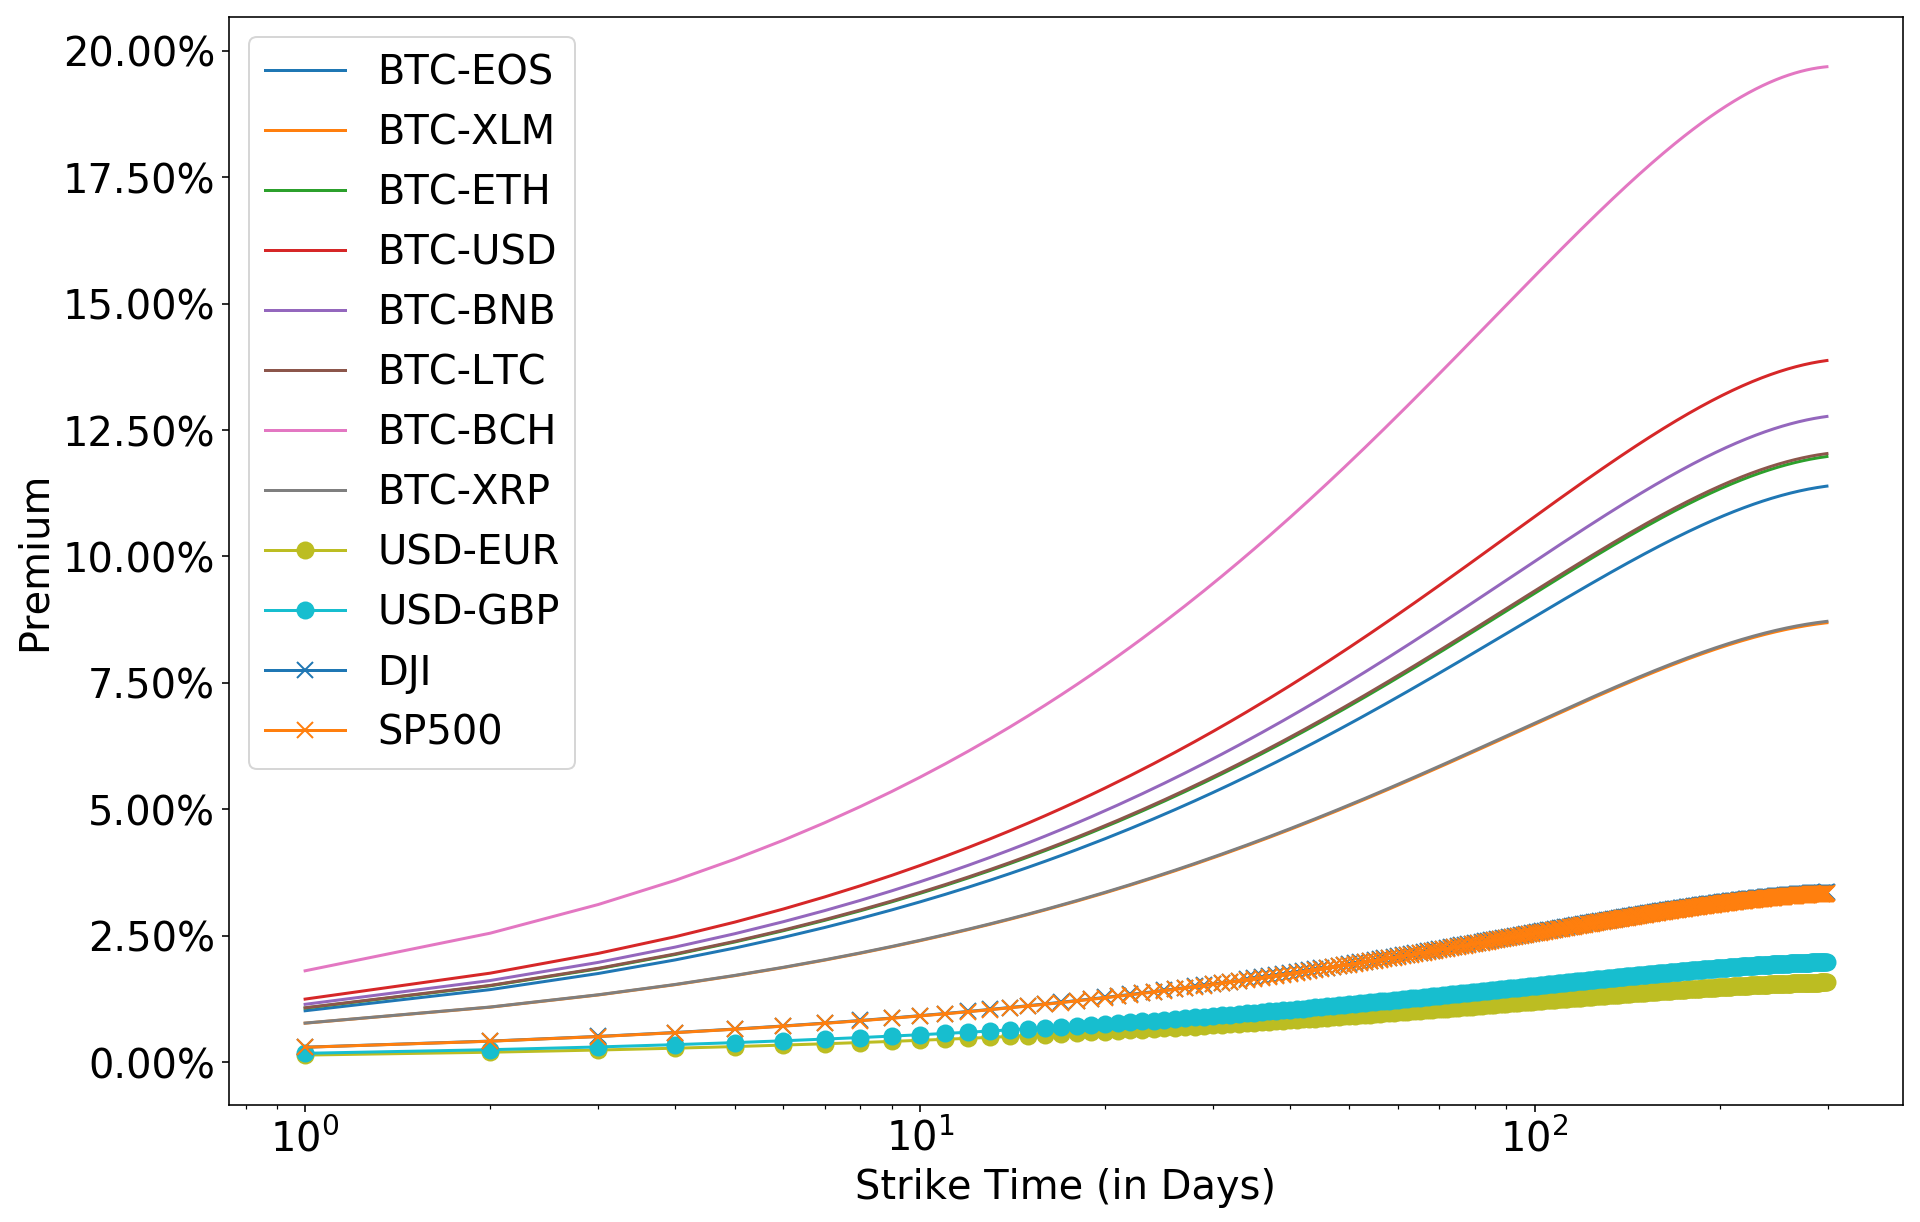

In [61]:
pairs = get_coin_pairs(f='btc')

fig = plt.figure(figsize=(15, 10))
for k, v in data.items():
    xs = np.arange(1.0, 300.0, 1.0)
    df = v[0]
    res = []
    for i in xs:
        res.append(price_atomic_swap2(df, 1000, i/365)['percentage_premiun'])
        
    if k == 'usd-gbp' or k == 'usd-eur':
        ma = 'o'
    elif k == 'sp500' or k == 'dji':
        ma = 'x'
    else:
        ma = ''
    plt.plot(xs, res, label=k.upper(), marker=ma, markersize=8)

# plt.yscale('log')
plt.xscale('log')

# ytick as percent
ax = plt.gca()
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

plt.xlabel('Strike Time (in Days)', fontsize=20)
plt.ylabel('Premium', fontsize=20)
plt.tick_params(axis='both', labelsize=20)

plt.legend(fontsize=20)
# plt.show()
plt.savefig('../../paper/figs/premium_pricing_result.eps')

## Volatility Analysis

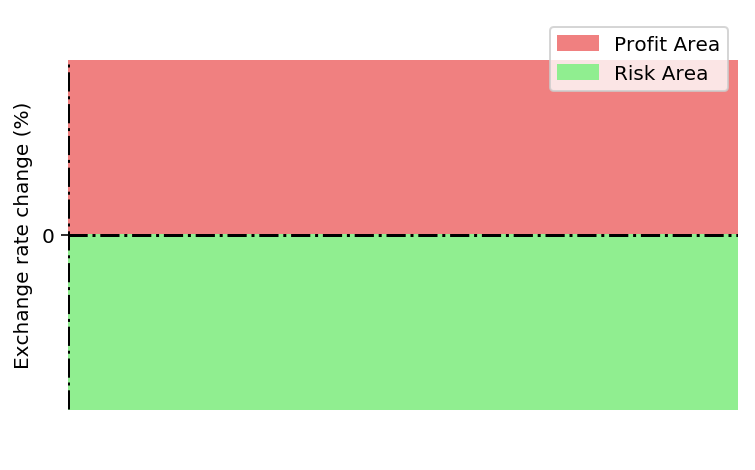

In [8]:
def unfair_diagram():
    fig, ax = plt.subplots(1)
    ax.margins(0) # remove default margins (matplotlib verision 2+)
    ax.add_patch(Rectangle((0, 0), 4, 4, color='lightcoral', label='Profit Area'))
    ax.add_patch(Rectangle((0, -4), 4, 4, color='lightgreen', label='Risk Area'))
    ax.plot([0, 5], [0, 0], 'black')
    ax.plot([0, 0], [-4, 4], 'black')
    ax.set_xlim([0, 4])
    ax.set_ylim([-5, 5])
    ax.set_ylabel('Exchange rate change (%)')
    ax.set_xticks([])
    ax.set_yticks([0])
    plt.box(False)
    plt.legend()
#     plt.show()
    plt.savefig('../../paper/figs/unfair_diagram.eps')
    
unfair_diagram()

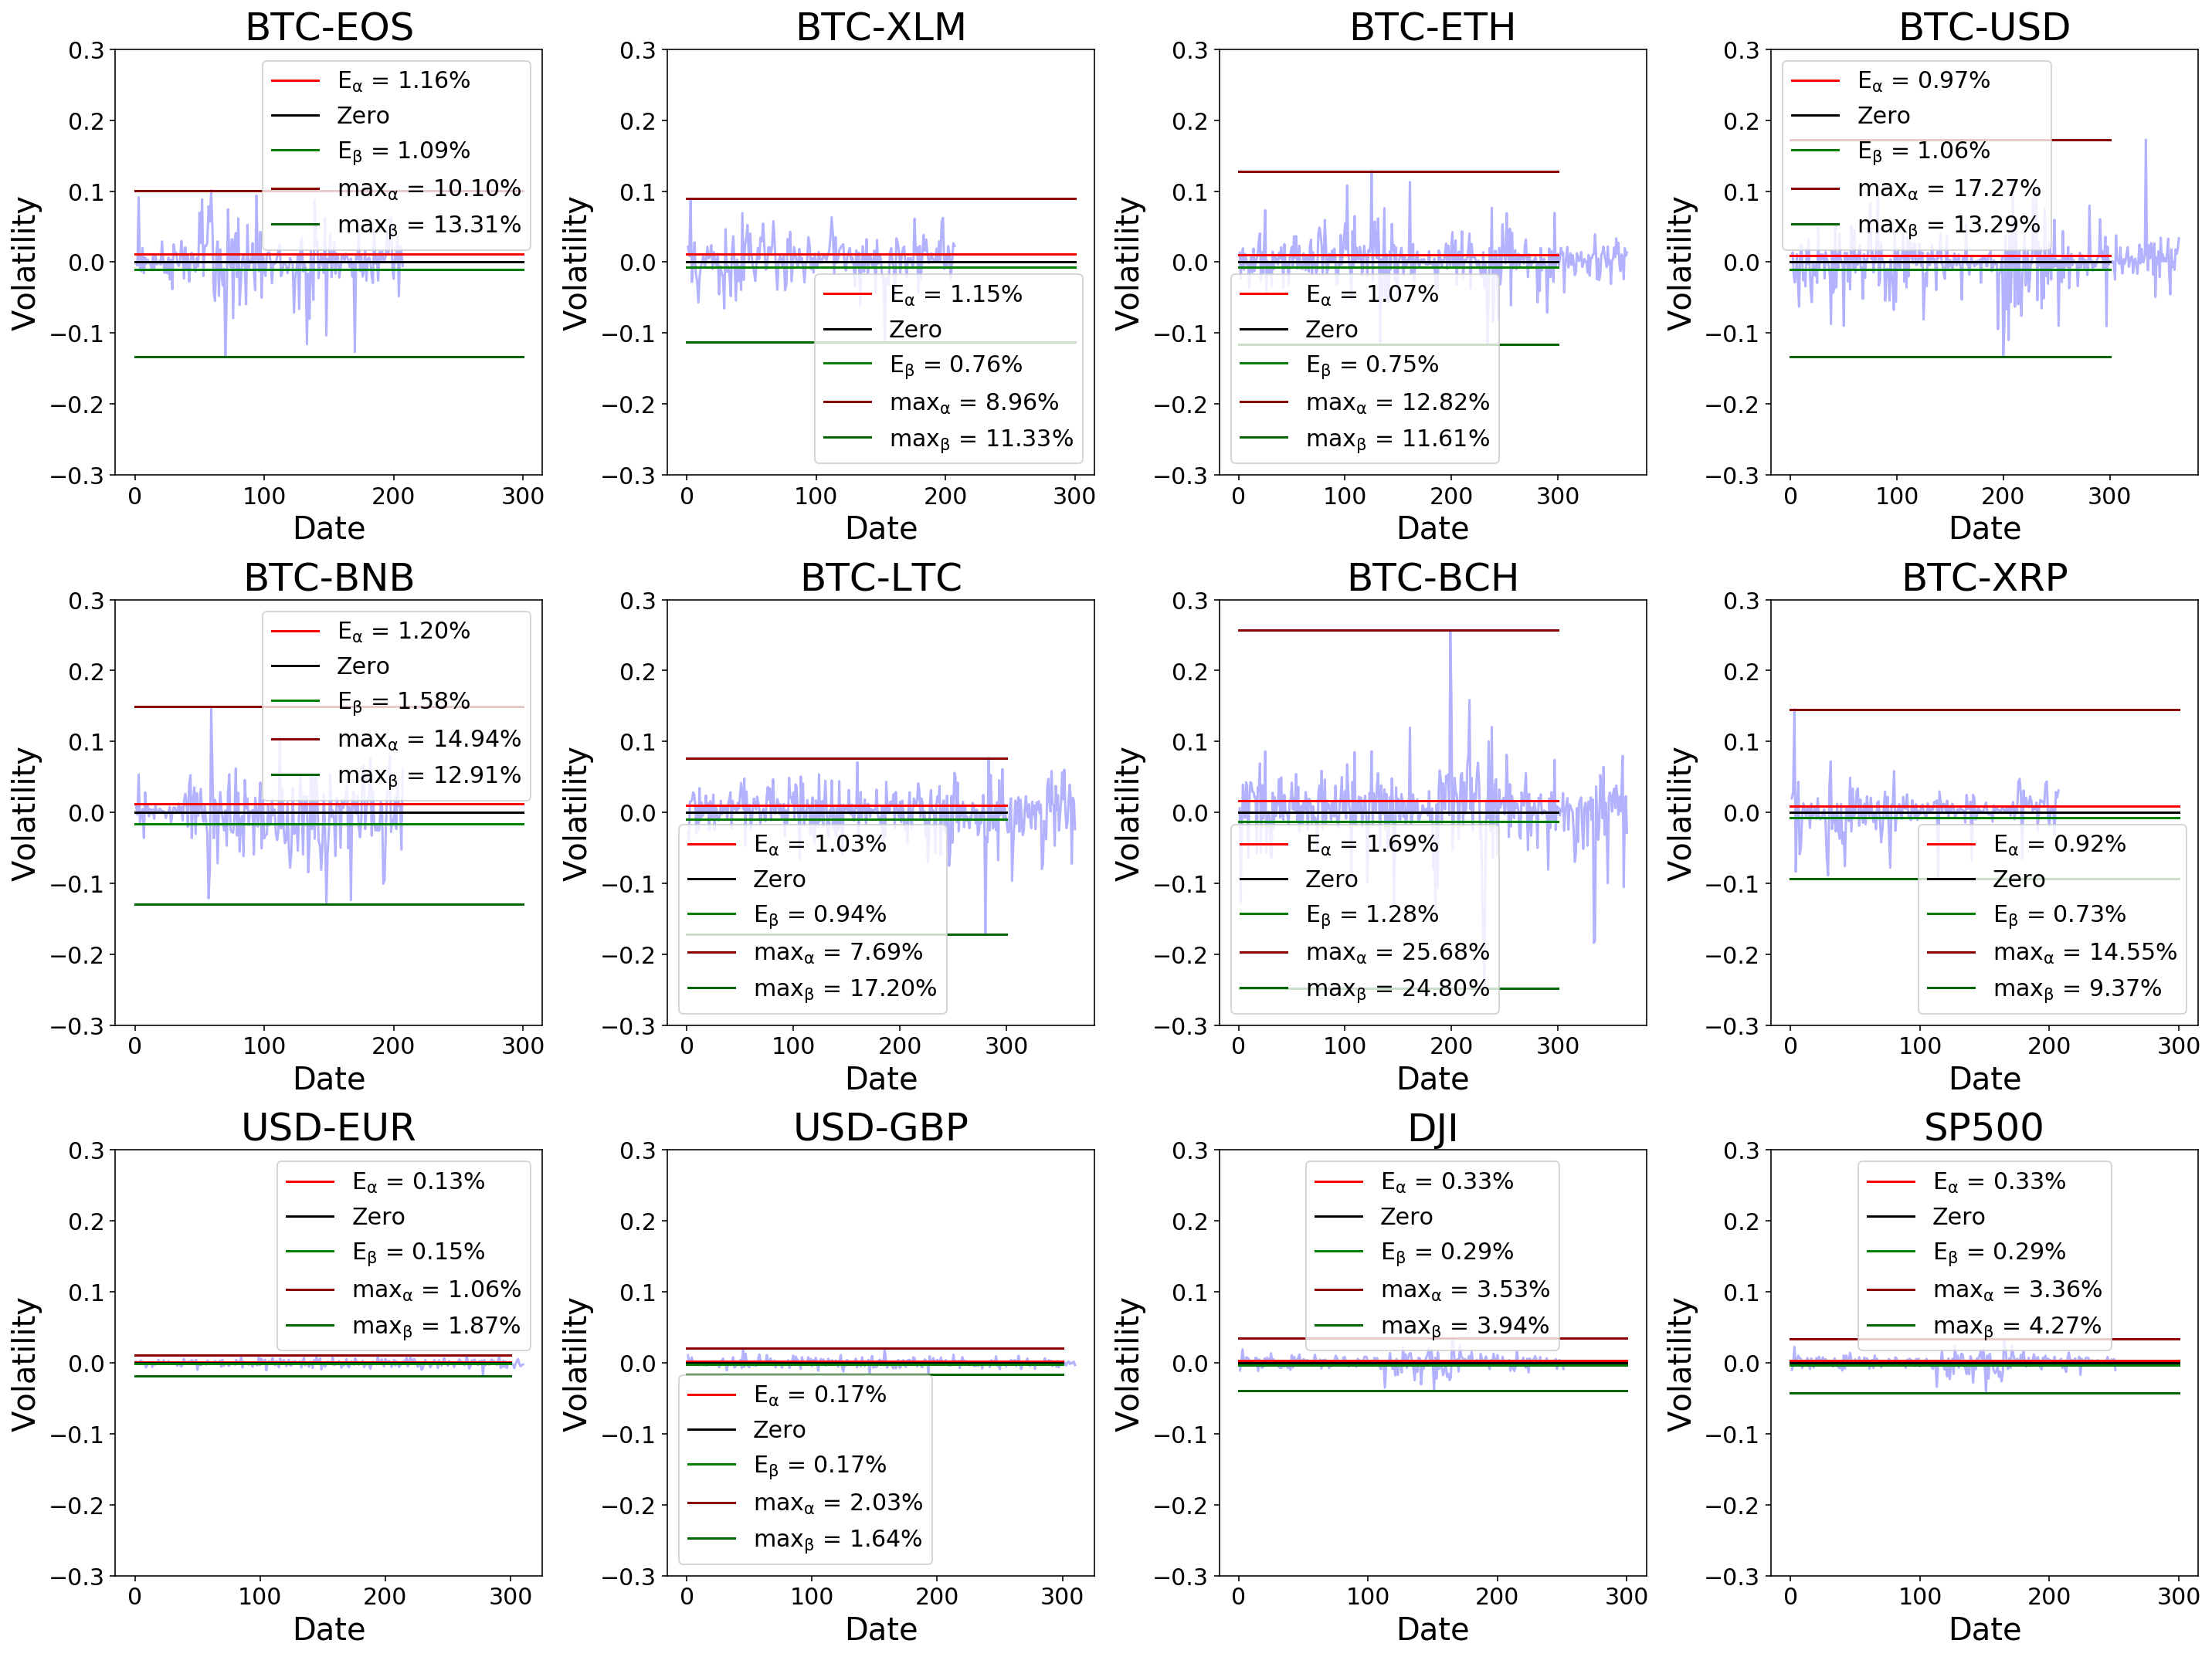

In [9]:
# plot
fig = plt.figure(figsize=(20, 15))
i = 1
for k, v in data.items():
    ax = fig.add_subplot(3, 4, i)
    i += 1
    
    # retrieve data
    df, v_info = v[0], v[1]
    v_ser = df['price_pct_change']
    up_max, down_max = v_ser.max(), v_ser.min()
    E_up = v_info[0] * v_info[1]
    E_down = v_info[2] * v_info[3]

    # plot line
    ax.plot(v_ser.astype('float').values, '-', color='blue', alpha=0.3)
    
    # up and down mean
    ax.plot([0, 300], [E_up, E_up], '-', color='red', label=r"$E_\alpha$ = {:.2f}%".format(E_up * 100))
    ax.plot([0, 300], [0, 0], '-', color='black', label='Zero')
    ax.plot([0, 300], [E_down, E_down], '-', color='green', label=r"$E_\beta$ = {:.2f}%".format(-E_down * 100))
    
    # up and down max
    ax.plot([0, 300], [up_max, up_max], '-', color='darkred', label=r"$max_\alpha$ = {:.2f}%".format(up_max * 100))
    ax.plot([0, 300], [down_max, down_max], '-', color='darkgreen', label=r"$max_\beta$ = {:.2f}%".format(-down_max * 100))
    
    # misc
    ax.set_ylabel('Volatility', fontsize=20)
    ax.set_xlabel('Date', fontsize=20)
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)
    ax.set_ylim([-0.3, 0.3])

    ax.set_title(k.upper(), fontsize=25)
    ax.legend(fontsize=15)

plt.tight_layout()
# plt.show()
plt.savefig('../../paper/figs/volatility_analysis.eps')

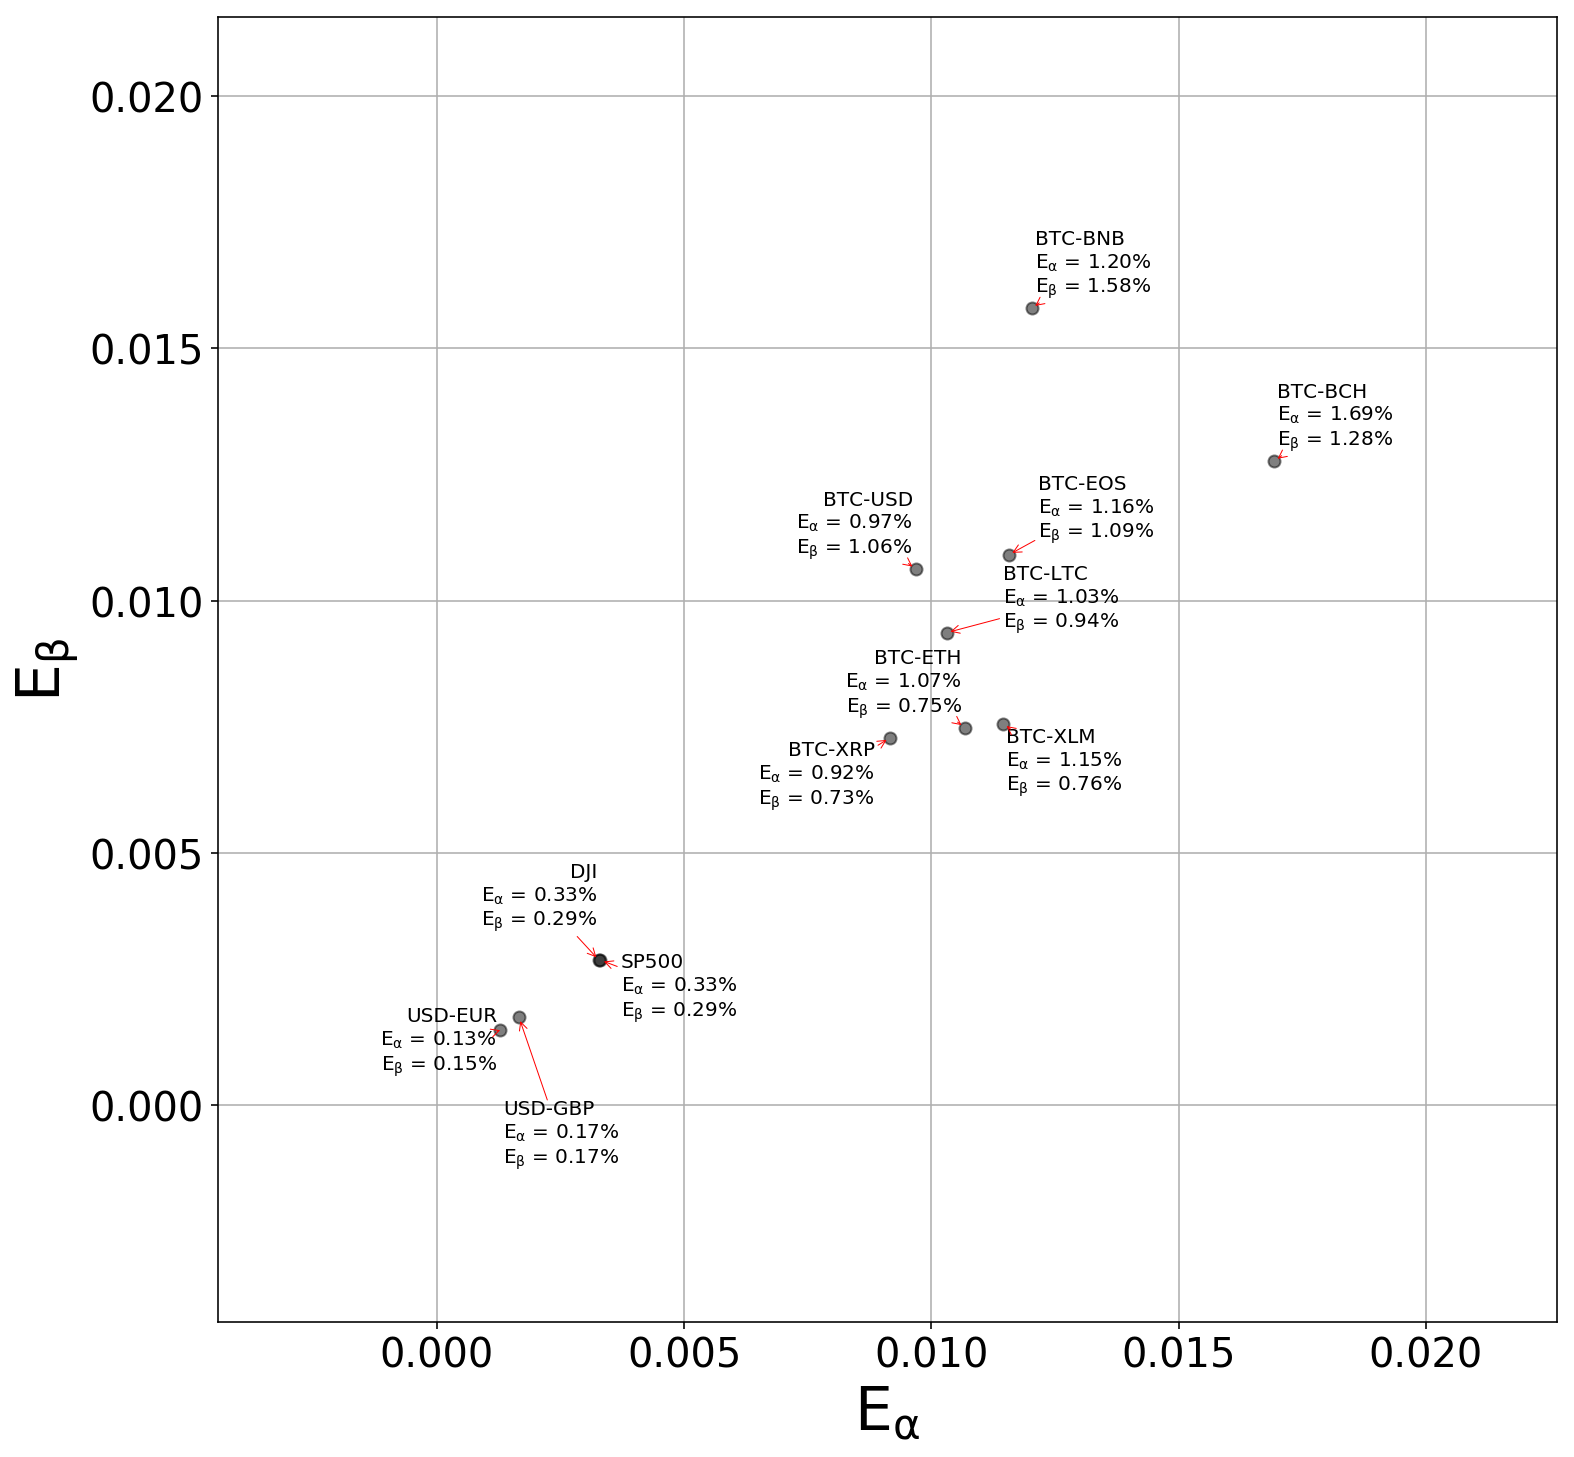

In [31]:
# get all data
Eups, Edowns = [], []
txts = []
for k, v in data.items():
    
    # retrieve data
    # retrieve data
    df, v_info = v[0], v[1]
    v_ser = df['price_pct_change']
    up_max, down_max = v_ser.max(), v_ser.min()
    E_up = v_info[0] * v_info[1]
    E_down = - v_info[2] * v_info[3]
    
    Eups.append(E_up)
    Edowns.append(E_down)

    txt = k.upper() + '\n' \
            + r'$E_\alpha$ = {:.2f}%'.format(E_up * 100) + '\n' \
            + r'$E_\beta$ = {:.2f}%'.format(E_down * 100)
    
    txts.append(txt)

# plot
fig = plt.figure(figsize=(12, 12))
p1 = plt.scatter(Eups, Edowns, color="black", alpha=0.5)
texts = []
for x, y, s in zip(Eups, Edowns, txts):
    texts.append(plt.text(x, y, s))
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))

# plt.xlim([0.005, 0.02])
# plt.ylim([0.005, 0.02])
plt.xlabel(r'$E_\alpha$', fontsize=30)
plt.ylabel(r'$E_\beta$', fontsize=30)
plt.tick_params(axis='both', labelsize=20)

plt.grid()
    
plt.savefig('../../paper/figs/vol_scatter.eps')